In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import get_dummies

%matplotlib inline
plt.style.use('ggplot')

from mhystic.preprocessing import *
from mhystic.embedding import *

import biovec
from sklearn.preprocessing import LabelEncoder
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

import glob

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

## Dataset

In [4]:
Bdata = pd.read_csv("bdata.csv")
Bdata.meas = [log_meas(i) for i in Bdata.meas]
data9mers = Bdata[Bdata.peptide_length == 9].reset_index()
peptides9mers = data9mers.sequence
sequences = Bdata.sequence

In [3]:
Bdata.tail()

species       mhc  peptide_length   cv   sequence inequality  meas
179687   human  HLAC1203               9  TBD  IMDEPTSSL          =   1.0
179688   human  HLAC1203               9  TBD  DAMPGVLSY          =   1.0
179689   human  HLAC1203               9  TBD  YYFQSGNEI          =   1.0
179690   human  HLAC1203               9  TBD  LMDENTYAM          =   1.0
179691   human  HLAC1203               9  TBD  FAAFYFVFI          =   1.0

In [4]:
data9mers.tail()

index species       mhc  peptide_length   cv   sequence inequality  \
129808  179687   human  HLAC1203               9  TBD  IMDEPTSSL          =   
129809  179688   human  HLAC1203               9  TBD  DAMPGVLSY          =   
129810  179689   human  HLAC1203               9  TBD  YYFQSGNEI          =   
129811  179690   human  HLAC1203               9  TBD  LMDENTYAM          =   
129812  179691   human  HLAC1203               9  TBD  FAAFYFVFI          =   

        meas  
129808   1.0  
129809   1.0  
129810   1.0  
129811   1.0  
129812   1.0

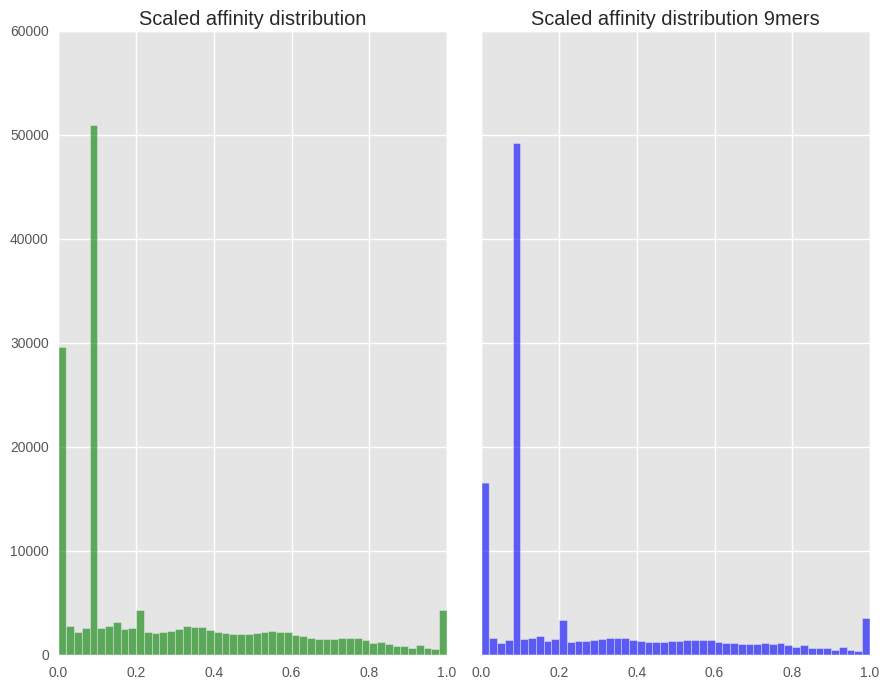

In [6]:
hist, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7), sharey=True)

ax1.set_title("Scaled affinity distribution")
hh =ax1.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

ax2.set_title("Scaled affinity distribution 9mers")
hh =ax2.hist(data9mers.meas, 50, color = 'blue', alpha = 0.6)
hist.tight_layout()
hist.subplots_adjust()


#### Selecting HLA alleles

In [6]:
hla_abce = select_hla(data9mers)
le = LabelEncoder()
mhc_labels = le.fit_transform(hla_abce.mhc)

In [4]:
hla_abce.to_csv("hla_abce.csv", index=False)

## Sequence2Vector
* Word2Vec
* Doc2Vec
* Database of human proteins from uniprot.org
* Peptides from mhc binders
* ProtVec

In [19]:
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    w2v_proteins = gensim.models.Word2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_proteins = train_seq2vec("uniprot-human.fasta")
    w2v_proteins.save("protein_model.pkl")

INFO : loading Word2Vec object from protein_model.pkl
INFO : setting ignored attribute syn0norm to None
INFO : setting ignored attribute cum_table to None
INFO : loaded protein_model.pkl
INFO : loading Doc2Vec object from peptides_model.pkl
INFO : setting ignored attribute cum_table to None
INFO : setting ignored attribute syn0norm to None
INFO : loaded peptides_model.pkl


In [ ]:
protvec_model = biovec.models.load_protvec('/home/rude_mhc/biovec/trained_models/swissprot_reviewed_protvec')

## Dataframes with 9mers peptides

#### 1. Sequence embedding
##### 1.1 Proteins from UniProt

In [30]:
mhc_seqs = pd.read_csv("mhc_seq_imghtla.csv").reset_index(drop=True)
mhc_seqs_dict = dict(zip(mhc_seqs.mhc, mhc_seqs.sequence))
mhc_seqs.tail()

mhc                                           sequence
98   HLAC0501  MRVMAPRTLILLLSGALALTETWACSHSMRYFYTAVSRPGRGEPRF...
99   HLAC0702  MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...
100  HLAC0401  MRVMAPRTLILLLSGALALTETWAGSHSMRYFSTSVSWPGRGEPRF...
101  HLAE0103  MVDGTLLLLLSEALALTQTWAGSHSLKYFHTSVSRPGRGEPRFISV...
102  HLAE0101  SHSLKYFHTSVSRPGRGEPRFISVGYVDDTQFVRFDNDAASPRMVP...

In [46]:
common = set(hla_abce.mhc.unique()).intersection(mhc_seqs.mhc.unique())
hla_abce = hla_abce.iloc[np.array(np.where(hla_abce.mhc.apply(lambda x: x in common))).flatten()].reset_index(drop=True)

In [47]:
hla_abce["mhc_protein"] = [mhc_seqs_dict[i] for i in hla_abce.mhc]

In [51]:
seq2vec_hlas = pd.DataFrame(hla_abce.sequence.apply(partial(seq2vec, w2v_proteins))).reset_index(drop=True)
seq2vec_hlas = pd.DataFrame(list(seq2vec_hlas.sequence))
seq2vec_hlas.columns = ["{}_{}".format('s2v', i) for i in seq2vec_hlas.columns]
seq2vec_hlas.tail()

s2v_0     s2v_1     s2v_2     s2v_3     s2v_4     s2v_5     s2v_6  \
116811 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116812 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116813 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116814 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   
116815 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   

           s2v_7     s2v_8     s2v_9   ...      s2v_170  s2v_171   s2v_172  \
116811  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116812  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116813  0.216265 -0.187837 -0.514041   ...     0.827864  0.79696 -0.204607   
116814 -0.370649  2.343495  1.851265   ...     0.827864  0.79696 -0.204607   
116815 -0.370649  2.343495  1.851265   ...     0.827864  0.79696 -0.204607   

         s2v_173   s2v_174   s2v_175   s2v_176   s2v_177   s2v_178  s2v_179  
116811 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116812 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116813 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116814 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  
116815 -0.807937 -0.245499  1.427431 -0.394118 -0.642358  0.442655 -0.44552  

[5 rows x 180 columns]

INFO : loading Word2Vec object from ctxt6_hs0_sg1_neg5.pkl
INFO : loading Word2Vec object from ctxt9_hs0_cbowmn0_neg5.pkl
INFO : loading Word2Vec object from ctxt6_hs0_cbowmn1_neg5.pkl
INFO : loading Word2Vec object from ctxt3_hs1_sg1_neg5.pkl
INFO : setting ignored attribute cum_table to None
INFO : setting ignored attribute syn0norm to None
INFO : loaded ctxt3_hs1_sg1_neg5.pkl


UnpicklingError opening ctxt6_hs0_sg1_neg5.pkl
UnpicklingError opening ctxt9_hs0_cbowmn0_neg5.pkl
UnpicklingError opening ctxt6_hs0_cbowmn1_neg5.pkl


INFO : loading Word2Vec object from ctxt3_hs0_cbowmn0_neg0.pkl
INFO : setting ignored attribute cum_table to None
INFO : setting ignored attribute syn0norm to None
INFO : loaded ctxt3_hs0_cbowmn0_neg0.pkl
INFO : loading Word2Vec object from ctxt9_hs1_sg1_neg5.pkl
INFO : setting ignored attribute cum_table to None
INFO : setting ignored attribute syn0norm to None
INFO : loaded ctxt9_hs1_sg1_neg5.pkl
INFO : loading Word2Vec object from ctxt3_hs0_sg1_neg0.pkl
INFO : loading Word2Vec object from ctxt9_hs1_cbowmn1_neg5.pkl
INFO : loading Word2Vec object from ctxt9_hs0_sg1_neg5.pkl


UnpicklingError opening ctxt3_hs0_sg1_neg0.pkl
UnpicklingError opening ctxt9_hs1_cbowmn1_neg5.pkl


INFO : loading Word2Vec object from ctxt6_hs1_sg1_neg0.pkl
INFO : setting ignored attribute cum_table to None
INFO : setting ignored attribute syn0norm to None
INFO : loaded ctxt6_hs1_sg1_neg0.pkl


UnpicklingError opening ctxt9_hs0_sg1_neg5.pkl


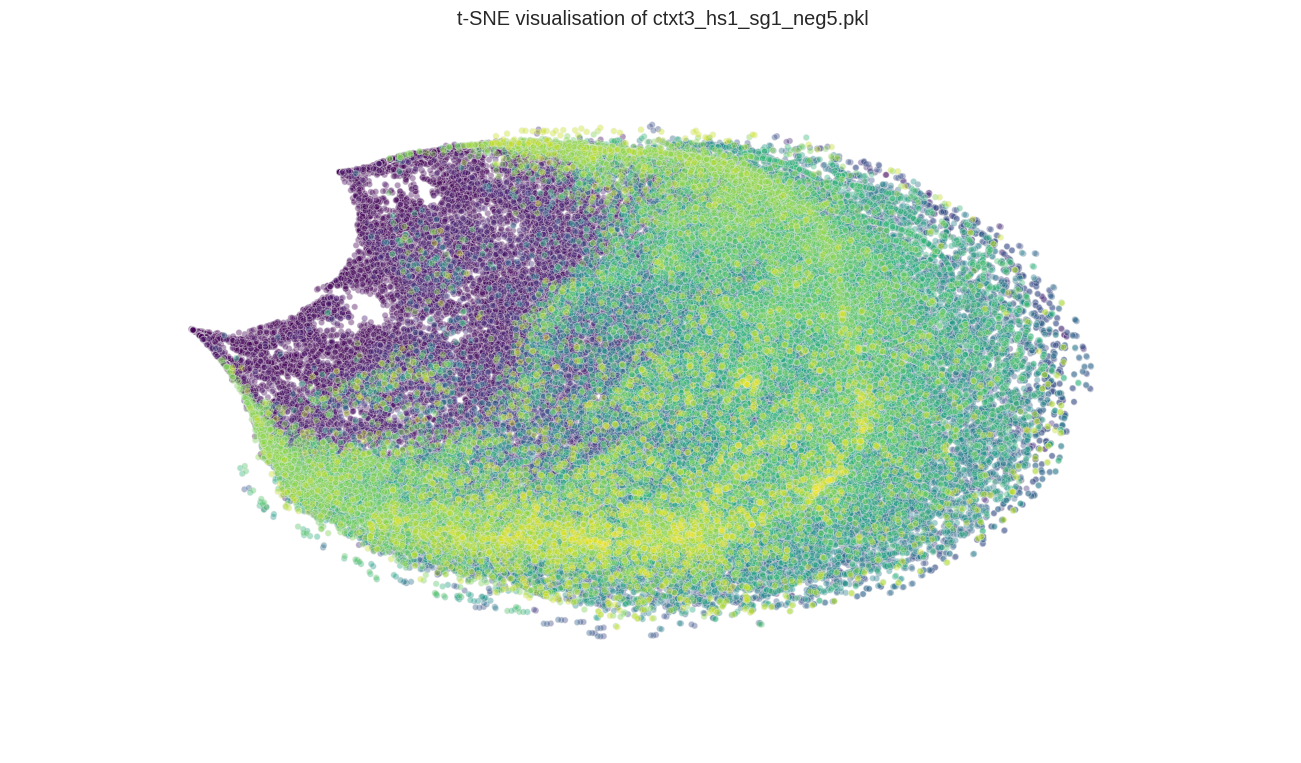

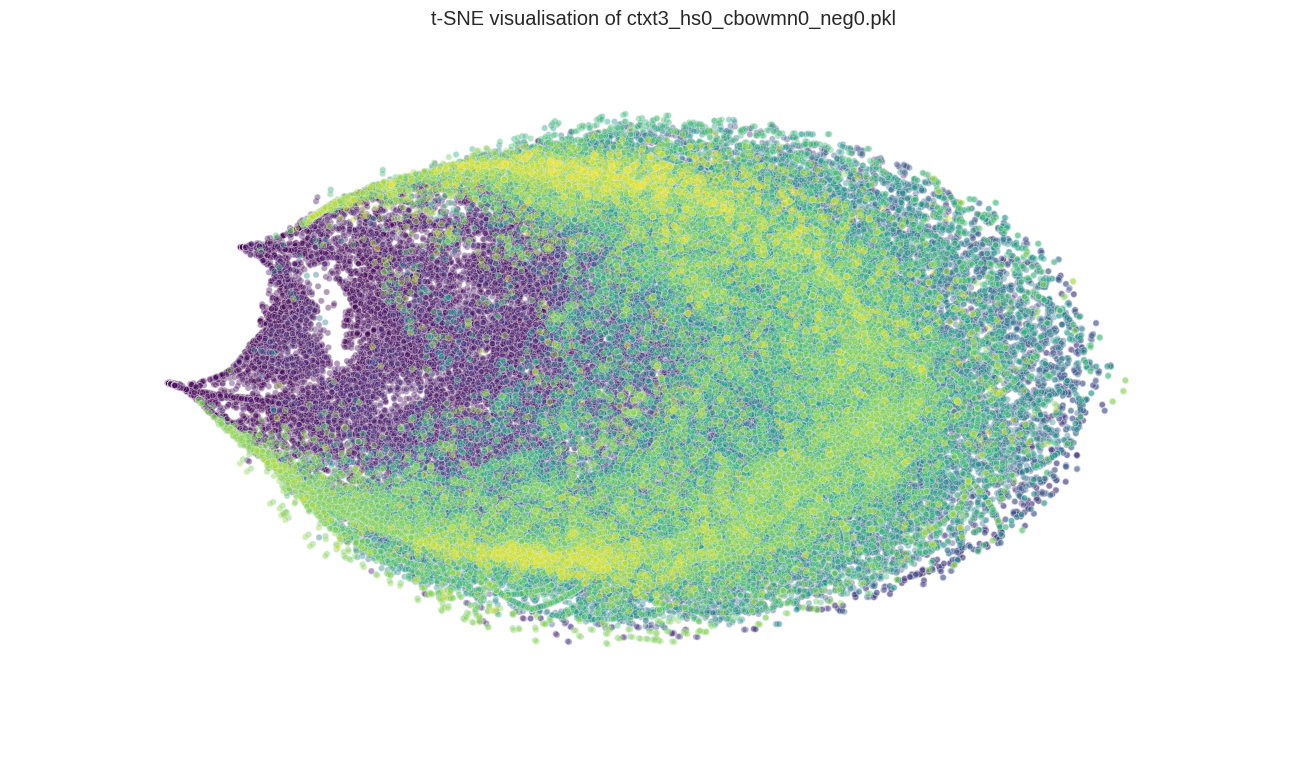

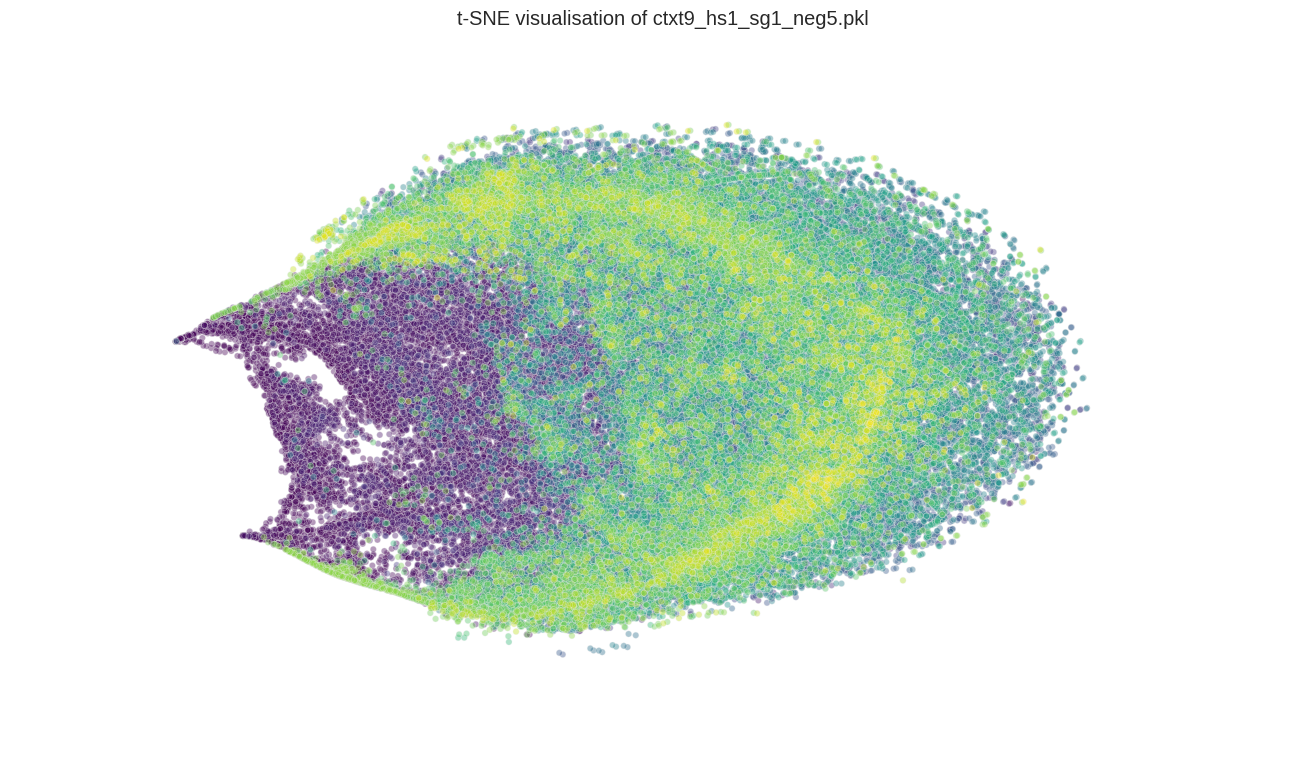

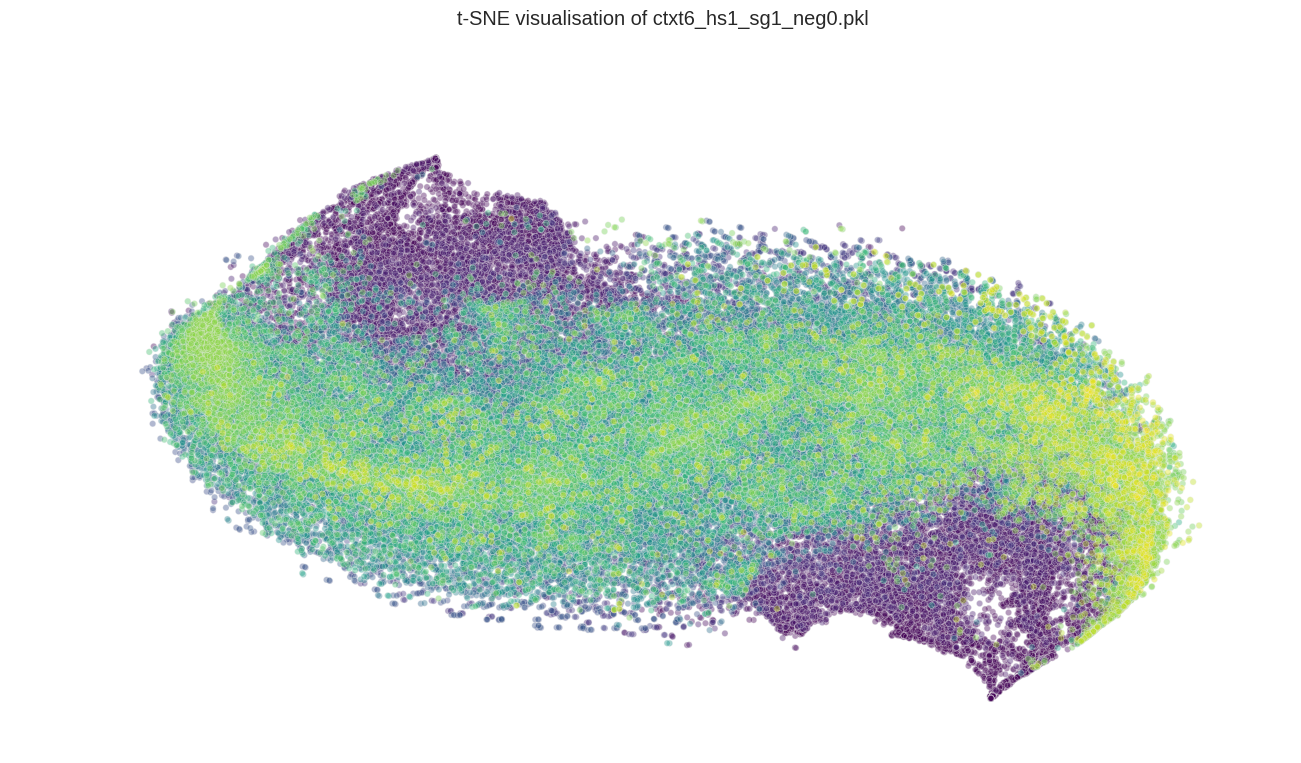

In [12]:
for cur_file in glob.glob('*.pkl'):
    try:
        cur_model =  gensim.models.Word2Vec.load(cur_file)
        cur_s2v = pd.DataFrame(hla_abce.sequence.apply(partial(seq2vec, cur_model))).reset_index(drop=True)
        cur_s2v = pd.DataFrame(list(cur_s2v.sequence))
        cur_s2v.columns = ["{}_{}".format('s2v', i) for i in cur_s2v.columns]
        plot_peptide_tsne(cur_s2v, mhc_labels, cur_file)
    except:
        print("UnpicklingError opening", cur_file)

In [53]:
mhc2protvec = pd.DataFrame(hla_abce.mhc_protein.apply(seq2protvec)).reset_index(drop=True)
mhc2protvec = pd.DataFrame(list(mhc2protvec.mhc_protein))
mhc2protvec.columns = ["{}_{}".format('mhc2pv', i) for i in mhc2protvec.columns]
mhc2protvec.tail()

mhc2pv_0   mhc2pv_1   mhc2pv_2   mhc2pv_3   mhc2pv_4   mhc2pv_5  \
116811  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116812  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116813  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116814  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   
116815  61.043465 -10.822474 -21.996658 -36.572334  61.595589  13.169536   

         mhc2pv_6   mhc2pv_7  mhc2pv_8   mhc2pv_9    ...      mhc2pv_90  \
116811  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116812  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116813  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116814  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   
116815  44.846344  12.401661 -36.91901  47.001892    ...      13.432936   

        mhc2pv_91  mhc2pv_92  mhc2pv_93  mhc2pv_94  mhc2pv_95  mhc2pv_96  \
116811  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116812  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116813  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116814  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   
116815  52.697014  13.844047 -12.146311  22.804787 -27.211864  39.433838   

        mhc2pv_97  mhc2pv_98  mhc2pv_99  
116811 -14.781194 -30.791248  64.284561  
116812 -14.781194 -30.791248  64.284561  
116813 -14.781194 -30.791248  64.284561  
116814 -14.781194 -30.791248  64.284561  
116815 -14.781194 -30.791248  64.284561  

[5 rows x 100 columns]

In [54]:
final_df = pd.concat([seq2vec_hlas, mhc2protvec], axis = 1)
final_df.tail()

s2v_0     s2v_1     s2v_2     s2v_3     s2v_4     s2v_5     s2v_6  \
116811 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116812 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116813 -1.218406 -1.948855 -0.295312 -0.050882 -0.659067 -0.421716  0.320015   
116814 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   
116815 -0.994039 -1.727786 -1.652630  0.016964  0.106538 -0.573591  1.658975   

           s2v_7     s2v_8     s2v_9    ...      mhc2pv_90  mhc2pv_91  \
116811  0.216265 -0.187837 -0.514041    ...      13.432936  52.697014   
116812  0.216265 -0.187837 -0.514041    ...      13.432936  52.697014   
116813  0.216265 -0.187837 -0.514041    ...      13.432936  52.697014   
116814 -0.370649  2.343495  1.851265    ...      13.432936  52.697014   
116815 -0.370649  2.343495  1.851265    ...      13.432936  52.697014   

        mhc2pv_92  mhc2pv_93  mhc2pv_94  mhc2pv_95  mhc2pv_96  mhc2pv_97  \
116811  13.844047 -12.146311  22.804787 -27.211864  39.433838 -14.781194   
116812  13.844047 -12.146311  22.804787 -27.211864  39.433838 -14.781194   
116813  13.844047 -12.146311  22.804787 -27.211864  39.433838 -14.781194   
116814  13.844047 -12.146311  22.804787 -27.211864  39.433838 -14.781194   
116815  13.844047 -12.146311  22.804787 -27.211864  39.433838 -14.781194   

        mhc2pv_98  mhc2pv_99  
116811 -30.791248  64.284561  
116812 -30.791248  64.284561  
116813 -30.791248  64.284561  
116814 -30.791248  64.284561  
116815 -30.791248  64.284561  

[5 rows x 280 columns]

NameError: name 'LabelEncoder' is not defined

#### 1.4 HLA binders. ProtVec

### 7. t-SNE

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=15, verbose=5, perplexity=100)

In [9]:
def plot_peptide_tsne(data, labels, description):
    
    """
    arguments:
    
    performance - 
    data - DataFrame with data for dimension reduction
    labels - np.array of colors for each point
    description - name for plot and npy array 
    
    --------
    function plot_peptide_tsne reduce dimension to 2 of high-dimensional representation in data and plots tsne 
    """
    
    tsne_repr = tsne.fit_transform(data.as_matrix())
    np.save('{}_tsne.npy'.format(description), tsne_repr)
    
    plt.figure(figsize=(16, 9))
    plt.title("t-SNE visualisation of {}".format(description))
    plt.scatter(tsne_repr[:,0], tsne_repr[:,1], c = labels, cmap='viridis', alpha=0.4)
    ax = plt.axis('off')
    plt.savefig('tsne_{}.png'.format(description), dpi='figure')

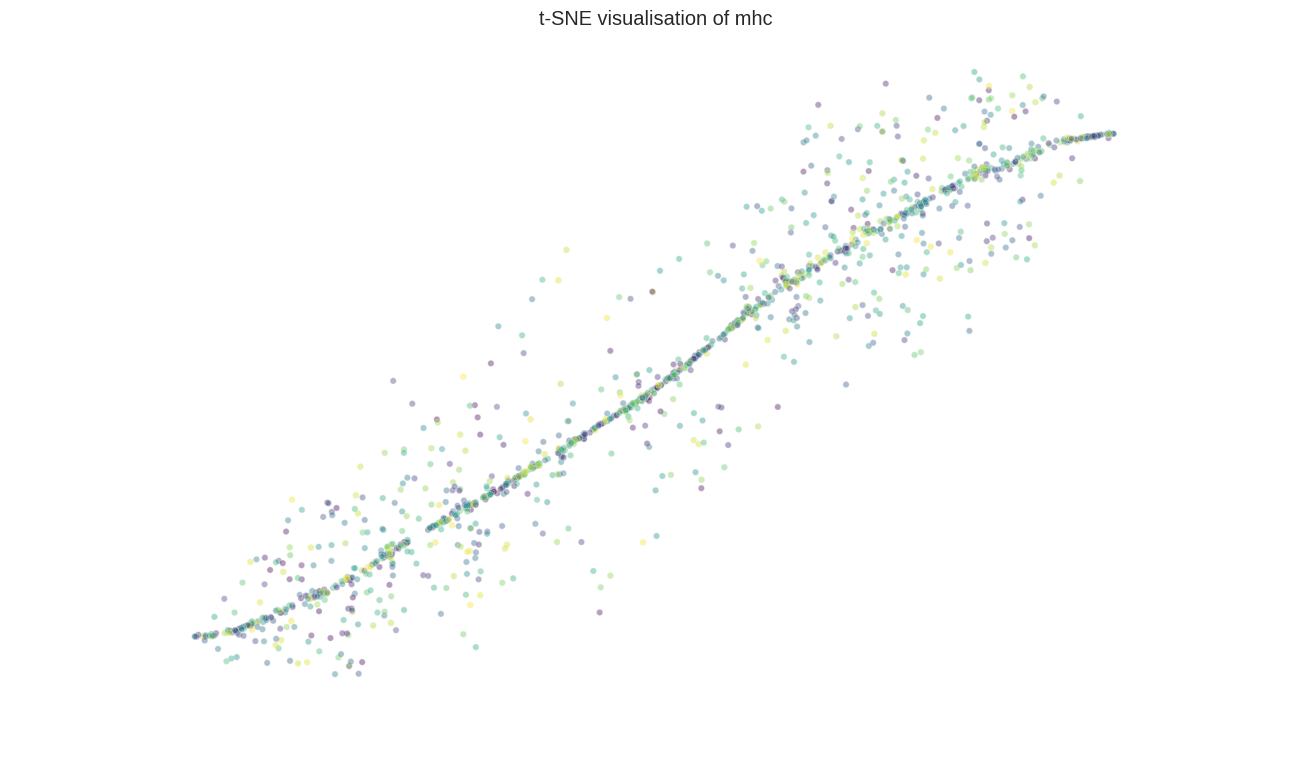

In [26]:
plot_peptide_tsne(seq2protvec_mhc, mhc_labels, "mhc")

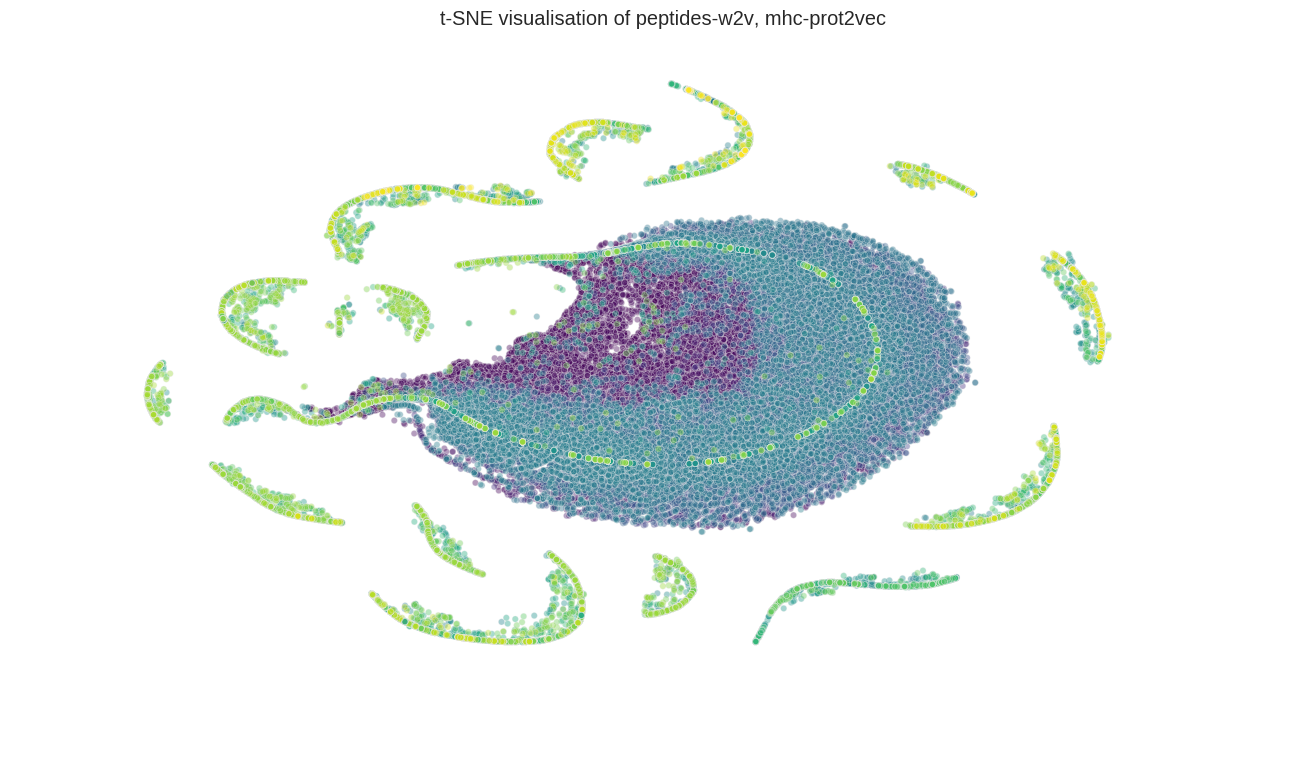

In [59]:
plot_peptide_tsne(final_df, mhc_labels, "peptides-w2v, mhc-prot2vec")

## Training XGboost

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [15]:
def xgb_grid_binary(model, params, data, target, cv=2):
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'min_child_weight': [4, 7], 
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(model, params, n_jobs=-1, cv=cv, verbose=1)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\AUC : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [16]:
def xgb_grid_regression(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    
    """dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)"""
    
    gbm_params = {
        'reg_lambda': [3]
    }
    

    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                                        subsample=0.9, colsample_bytree = 0.9,
                                        nthread=14, silent=False), gbm_params, n_jobs=14, cv=3, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS(validation): ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nRMSE on test : %.4g\n==================" % metrics.mean_squared_error(y_test, predictions))
    
    

In [17]:
def xgb_regression(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    """
    T_train_xgb = xgb.DMatrix(X_train, y_train)
    params = {"objective": "reg:linear", 'max_depth':9,
              'learning_rate':0.1, 'n_estimators':750, 'gamma':0, 'min_child_weight':5, 
              'reg_lambda': 0.3, 'subsample': 0.9, 'colsample_bytree':0.9, 'nthread':15}
    
    #cv_res=xgb.cv(params,xgall,100, 3, verbose_eval= 10, metrics='mse', folds=sample_cv)
    gbm = xgb.train(dtrain=T_train_xgb,params=params, num_boost_round=1000)
    pred = gbm.predict(xgb.DMatrix(X_test))
    print("RMSE on test: %.4f" % mean_squared_error(y_test, pred))
    
    """
    
    xgbr = xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                            reg_lambda = 0.3, subsample=0.9, colsample_bytree = 0.9, nthread=15, silent=False)
    
    xgbr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, xgbr.predict(X_test))
    print("RMSE on test: %.4f" % mse)
    return mse


### Model evaluation

In [ ]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
#affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [ ]:
gbm_params = {
        'min_child_weight': [4, 7], 
    }
xgb_grid_binary(xgb.XGBClassifier(), gbm_params, seq2vec9mers_proteins, affinity_binary)

In [ ]:
xgb_regression(pd.concat([seq2vec_hla, pd.DataFrame(hla_tsne, columns=["x_tsne", "y_tsne"])], axis = 1), affinity_hlas)

In [ ]:
#learning_rate and n_estimators tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [ ]:
#max_depth and min_child_weight tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [ ]:
#gamma tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

In [ ]:
#tree structure tuning
xgb_regression(seq2vec_hla, affinity_hlas)

In [ ]:
### 1hot HLA
xgb_regression(seq2vec_hla, alleles_ABCE.meas)

In [ ]:
data1 = pd.read_csv("")

In [33]:
xgb_regression(seq2protvec_9mers, hla_abce.meas)

RMSE on test: 0.0586


##  Pipeline

#### objective
* visualise RMSE on every allele

#### steps

* make dataset with sequences and affinities for specific allele
* construct word2vec representation of this sequences
* evaluate xgb model on it
* make 
    
#### important
* gather size of each dataset



In [115]:
from operator import itemgetter
from collections import OrderedDict
import matplotlib.ticker as ticker
import re

In [8]:
def get_rmse_of_models(performance, alleles, my_performnace):
    
    """
    arguments:
    
    performance - 
    alleles - list of alleles names
    my_performnace - 
    
    --------
    function get_rmse_of_models extract dataset of specific allele from performance dataset, calculates rmse on 
    each allele and stores it in dicts
    --------
    returns: 3 tuples
    
    netmhc_rmse - tuple of rmse of netmhc on every alelle
    netmhcpan_rmse - tuple of rmse of netmhcpan on every alelle
    pmbec_rmse - tuple of rmse of smm_pmbec on every alelle
    
    """
    
    netmhc_rmse = {}
    netmhcpan_rmse = {}
    pmbec_rmse = {}
    
    for index, cur_al in enumerate(alleles):
        
        cur_alelle = select_by_allele(performance, cur_al)
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", cur_alelle.shape, cur_alelle.meas.shape)
        if(len(cur_alelle) == 0):
            continue
        netmhc_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhc)
        netmhcpan_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhcpan)
        pmbec_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.smmpmbec_cpp)
    
    xgb_df = pd.DataFrame.from_dict(my_performance, orient='index')
    netmhc_df = pd.DataFrame.from_dict(netmhc_rmse, orient='index')
    netmhcpan_df = pd.DataFrame.from_dict(netmhcpan_rmse, orient='index')
    pmbec_df = pd.DataFrame.from_dict(pmbec_rmse, orient='index')

    models_perf = pd.concat([xgb_df, netmhc_df, netmhcpan_df, pmbec_df], axis=1)
    models_perf.columns=["xgb", "netmhc", "netmhcpan", "pmbec"]
    
    return models_perf


def evaluate_by_allele(w2vmodel, dataset, alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function evaluate_by_allele extract dataset of specific allele from Bdata in which there are sequence and affinity 
    using select_by_allele function, saves it in csv, then constructing word2vec representation of this 
    sequences and evaluates xgb model, which return rmse on this allele.
    --------
    returns: 
    
    mhc_rmse tuple of rmse on every allele in alleles
    """
    
    mhc_rmse = {}
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        if(len(current_allele) == 1):
            continue
        seq2vec_allele = pd.DataFrame(current_allele.sequence.apply(partial(seq2protvec, w2v_3grams)), columns=["sequence"])
        seq2vec_allele = pd.DataFrame(list(seq2vec_allele.sequence))
        seq2vec_allele.to_csv("../mhc/w2v_allele#{}.csv".format(cur_al))
        cur_al_affinity = current_allele.meas
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        allele_rmse = xgb_regression(seq2vec_allele, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
    
    return mhc_rmse

def evaluate_by_allele_protvec(dataset, alleles):
    
    mhc_rmse = {}
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(dataset, cur_al)
        
        if(len(current_allele) == 1):
            continue
        
        cur_s2pv = pd.DataFrame(current_allele.sequence.apply(seq2protvec))
        cur_s2pv = pd.DataFrame(list(cur_s2pv.sequence))
        
        cur_al_affinity = current_allele.meas
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        allele_rmse = xgb_regression(cur_s2pv, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
    
    return mhc_rmse

def plot_results(results, description):
    
    """
    results - DataFrame with columns "xgb", "netmhc", "netmhcpan", "pmbec"
    
    """

    allele_rmse_figure = plt.figure(figsize=(48, 27))
    plt.title("RMSE.{}".format(description))
    plt.xlabel("$RMSE$")
    plt.ylabel("Alleles")

    ind = np.arange(0, 4*len(list(results.index)), 4) 
    width = 0.6
    ys = plt.yticks(ind, list(results.index), rotation=0)
    plt.locator_params(nbins=len(results.xgb))

    xgb_rects = plt.barh(ind, list(results.xgb), width, align='center', color='red', alpha=0.3, label = 'xgb', edgecolor='w')
    plt.barh(ind + width , list(results.netmhc), width, align='center', color='yellow', alpha=0.3, label='netmhc')
    plt.barh(ind + 2*width, list(results.netmhcpan), width, align='center', color='blue', alpha=0.3, label='netmhcpan')
    plt.barh(ind + 3*width, list(results.pmbec), width, align='center', color='black', alpha=0.3, label='pmbec')

    plt.legend(fontsize='xx-large')


    rounded_rmse_xgb = ["{0:.5f}".format(i) for i in list(results.xgb)]

    for cur_rect, value in zip(xgb_rects.patches, rounded_rmse_xgb):
        plt.text(cur_rect.get_width() +0.001, cur_rect.get_y() - 0.5, value, ha='center', va='bottom')


    allele_rmse_figure.savefig('rmse {}.png'.format(description), dpi=allele_rmse_figure.dpi)

In [9]:
performance_data = pd.read_csv("model_performance_logged.csv").drop("Unnamed: 0", axis=1)
performance_data.tail()

mhc      meas    netmhc  netmhcpan  smmpmbec_cpp
21377  Mamu-A02  0.747391  0.434557   0.605658      0.567139
21378  Mamu-A02  0.022339  0.293037   0.202166      0.371139
21379  Mamu-A02  0.028511  0.283247   0.148324      0.273245
21380  Mamu-A02  0.141940  0.079586   0.195356      0.143642
21381  Mamu-A02  0.535430  0.496485   0.389441      0.569267

In [60]:
unify_alleles = lambda x: re.sub('[*|:|-]', '', x)

performance_data.mhc.replace(unify_alleles, inplace=True)
data9mers.mhc.replace(unify_alleles, inplace=True)

common_alleles = list(set(data9mers.mhc).intersection(performance_data.mhc))

In [67]:
errors = evaluate_by_allele_protvec(data9mers, common_alleles)
np.save("xgb_rmse_9mers_protvec.npy", errors) #skl
errors = OrderedDict(sorted(errors.items(), key=lambda t: t[0]))
performance_df = get_rmse_of_models(performance_data, common_alleles, errors)


#0 HLAB0702:
Shapes:  (589, 4) (589,)

#1 HLAA3201:
Shapes:  (256, 4) (256,)

#2 HLAA2402:
Shapes:  (346, 4) (346,)

#3 HLAB3901:
Shapes:  (641, 4) (641,)

#4 HLAB3801:
Shapes:  (351, 4) (351,)

#5 HLAA1101:
Shapes:  (514, 4) (514,)

#6 MamuA02:
Shapes:  (125, 4) (125,)

#7 HLAA0203:
Shapes:  (460, 4) (460,)

#8 HLAB3501:
Shapes:  (341, 4) (341,)

#9 HLAB2705:
Shapes:  (249, 4) (249,)

#10 HLAA2301:
Shapes:  (242, 4) (242,)

#11 HLAB4001:
Shapes:  (243, 4) (243,)

#12 HLAA2603:
Shapes:  (312, 4) (312,)

#13 HLAB1517:
Shapes:  (582, 4) (582,)

#14 HLAA0201:
Shapes:  (1778, 4) (1778,)

#15 HLAB5801:
Shapes:  (275, 4) (275,)

#16 HLAB0802:
Shapes:  (509, 4) (509,)

#17 HLAA0101:
Shapes:  (479, 4) (479,)

#18 HLAB5701:
Shapes:  (647, 4) (647,)

#19 HLAB0801:
Shapes:  (707, 4) (707,)

#20 HLAB1501:
Shapes:  (633, 4) (633,)

#21 HLAB1503:
Shapes:  (165, 4) (165,)

#22 MamuA01:
Shapes:  (73, 4) (73,)

#23 HLAA6901:
Shapes:  (470, 4) (470,)

#24 HLAA3002:
Shapes:  (267, 4) (267,)

#25 HLAB440

In [82]:
plot_peptide_tsne

<function numpy.core.multiarray.where>